<a href="https://colab.research.google.com/github/Andrewpensoneault/bounded_gp_regression/blob/master/BoundedGaussianProcessRegressionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bounded Gaussian Process Regression 
### Andrew Pensoneault


###Necessary Libraries

In [0]:
%%capture
!pip install pyDOE
!pip install cma
import cma
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy.linalg as linalg
from pyDOE import *
import math
import os
from scipy.optimize import minimize
import random

### Necessary Functions

####Kernel function

In [0]:
def gausskern(x1,x2,sigma,theta):
  Nk = len(x1)
  invtheta = 1/(theta)**2
  if len(x1.shape) == 1:
    x1 = np.reshape(np.array(x1),Nk,1)
    x2 = np.reshape(np.array(x2),Nk,1)
    x1 = np.expand_dims(x1,1)
    x2 = np.expand_dims(x2,1)
    invtheta = np.expand_dims(invtheta,1)
  invtheta = np.diag(invtheta)
  diffx1x2 = x1-x2
  diffx1x2t = np.transpose(diffx1x2)
  expval = -.5*(diffx1x2t @ invtheta) @ diffx1x2
  y = (sigma**2)*np.exp(expval)
  return y

Make $K$ and $k^*$

In [0]:
def makeK(X,sigma,theta,a=.00001):
  N = X.shape[1]
  K = np.zeros([N,N])
  for i in range(0,N):
    for j in range(i,N):
      K[i,j] = gausskern(X[:,i],X[:,j],sigma,theta)
      K[j,i] = K[i,j]
  K = K + a*np.eye(N,N)
  return K

def makeKinv(X,sigma,theta,a=.00001):
  K = makeK(X,sigma,theta,a)
  Kchol = linalg.cholesky(K)
  Kcholinv = linalg.inv(Kchol)
  Kinv = np.transpose(Kcholinv) @ Kcholinv
  return Kinv

def makediagKinv(X,sigma,theta,a=.00001):
  Kinv = makeKinv(X,sigma,theta,a)
  diagKinv = np.diag(np.diag(Kinv))
  return diagKinv

def makekstar(xstar,X,sigma,theta):
  xstar = np.reshape(xstar,[],1)
  N = X.shape[1]
  kstar = np.zeros([N,1])
  for i in range(0,N):
    kstar[i,0] = gausskern(X[:,i],xstar,sigma,theta)
  return kstar

def makekstarmat(xstarmat,X,sigma,theta):
  nsamp = xstarmat.shape[1]
  kstarmat = np.transpose(np.squeeze(np.array([makekstar(xstarmat[:,i],X,sigma,theta) for i in range(0,nsamp)])))
  return kstarmat

#### Mean and Variance for Gaussian Regression

In [0]:
def meangaussreg(xstarmat,Y,X,sigma,theta,a=.00001):
  Kinv = makeKinv(X,sigma,theta,a)
  kstarmat = makekstarmat(xstarmat,X,sigma,theta)
  if len(kstarmat.shape):
    kstarmat = np.expand_dims(kstarmat,1)
  mu = np.transpose(kstarmat) @ Kinv @ Y
  return mu

def covargaussreg(xstarmat,Y,X,sigma,theta,a=.00001):
  nsamp = xstarmat.shape[1]
  Kinv = makeKinv(X,sigma,theta,a)
  Kstar = makeK(xstarmat,sigma,theta,0)
  KstarX = makekstarmat(X,xstarmat,sigma,theta)
  sig2 = Kstar-KstarX @ (Kinv @ np.transpose(KstarX))
  return sig2

#### Helper functions and Mean and Variance for Projection

In [0]:
def diffnormalcdf(mean,var,a,b):
  y = stats.norm.cdf(a,mean,np.sqrt(var))-stats.norm.cdf(b,mean,np.sqrt(var))
  return y

def diffnormalpdf(mean,var,a,b):
  y = stats.norm.pdf(a,mean,np.sqrt(var))-stats.norm.pdf(b,mean,np.sqrt(var))
  return y

def projmeangaussreg(X,Y,Kinv,i,xstar,sigma,theta,left,right):
  KinvY = Kinv @ Y
  muf = (Y[i] - KinvY[i])/Kinv[i,i]
  sig2f = 1/Kinv[i,i]
  lxtest = left(xstar)
  rxtest = right(xstar)
  alpha = (lxtest-muf)/np.sqrt(sig2f)
  beta = (lxtest-muf)/np.sqrt(sig2f)
  Z = diffnormalcdf(muf,sig2f,lxtest,rxtest)
  mu = Z*muf+diffnormalpdf(0,1,alpha,beta)*np.sqrt(sig2f)+lxtest*stats.norm.cdf(alpha,0,1)+rxtest*(1-stats.norm.cdf(beta,0,1))
  return mu

def projvargaussreg(X,Y,i,xstar,sigma,theta,left,right):
  Kinv = makeKinv(X,sigma,theta)
  KinvY = Kinv @ Y
  muf = (Y[i] - KinvY[i])/Kinv[i,i]
  sig2f = 1/Kinv[i,i]
  lxtest = left(xstar)
  rxtest = right(xstar)
  alpha = (lxtest-muf)/np.sqrt(sig2f)
  beta = (lxtest-muf)/np.sqrt(sig2f)
  Z = diffnormalcdf(muf,sig2f,lxtest,rxtest)
  mug = projmeangaussreg(X,Y,i,xstar,sigma,theta,left,right)
  sigg2 =Z*(muf**2+sig2f)+2*muf*np.sqrt(sig2f)*diffnormalpdf(0,1,alpha,beta)+sig2f*(alpha*stats.norm.pdf(alpha,0,1)-beta*stats.norm.pdf(beta,0,1))+lxtest**2*stats.norm.cdf(alpha,0,1)+rxtest**2(1-stats.norm.cdf(beta,0,1))-mug
  return sigg2

#### Optimization Objective Functions for Parameter Selection

##### Unbounded

In [0]:
def unboundobjfunc(x,X,Y):
  f = 0
  Kinv = makeKinv(X,1,x[0])
  N = X.shape[1]
  KinvY = Kinv @ Y
  for i in range(0,N):
    f = f + (KinvY[i]/Kinv[i,i])**2
  return f[0]


def unboundsigma(X,Y,theta):
  N = X.shape[1]
  Kinv = makeKinv(X,1,theta)
  diagKinv = makediagKinv(X,1,theta)
  diagKinvinv = linalg.inv(np.diag(np.diag(Kinv)))
  sig2 = (1/N) * (np.transpose(Y) @( Kinv @ (diagKinvinv @ (Kinv @ Y))))
  return sig2

#####Bounded 

In [0]:
def boundobjfunc(x,X,Y,left,right,cl,cu):
  N = X.shape[1]
  Kinv = makeKinv(X,x[0],x[1:])
  diagKinv = np.diag(np.diag(Kinv))
  diagKinvinv = linalg.inv(np.diag(np.diag(Kinv)))
  KinvY = Kinv @ Y
  innerg = (1/N)*((((np.transpose(Y) @ Kinv) @ diagKinvinv) @ Kinv) @ Y)
  g1 = ((x[0]-cl*innerg)>=0)
  g2 = (cu*innerg - x[0]>=0)
    
  if (g1 and g2) == False:
    f = 10000000
  else:
    f = 0
    for i in range(0,N):
      xstar = X[:,i]
      mugni = projmeangaussreg(X,Y,Kinv,i,xstar,x[0],x[1:],left,right)
      f = f + (Y[i]-mugni)**2
    f = f[0]
  return f

### Test Using 1D Example 3 from *Bounded Regression with Gaussian Process Projection*

In [0]:
random.seed(3)
N = 15
dim = 1
nsamp = 1000
xmin = -np.pi/8
xmax = np.pi/8
sigma = np.ones((1,1))
theta = .1*np.ones((1,dim))
cu = 10**2
cl = 10**-2
num_test_gp = 50

##### Design, Response, and other parameters to be used between trials

Function to be regressed

In [0]:
def sini(x):
  x = np.array(x)
  y = np.zeros(x.shape)
  r=(x!=0)
  tmp = x[r]
  if len(tmp) != 0:
    y[r] = tmp**2*np.sin(tmp**(-1))
  return y

Latin Hypercube design matrix, response matrix, and uniform test samples

In [0]:
X = np.transpose(lhs(1,N))*(xmax-xmin)+xmin
Y = np.transpose(sini(X))
xtest = np.array([np.linspace(xmin,xmax,nsamp)])

Prenormalized values of input and output

In [0]:
xtestnorm = (xtest-np.mean(xtest))/np.std(xtest);
Xnorm = (X-np.mean(X))/np.std(X);
Ynorm = (Y-np.mean(Y))/np.std(Y);

In [0]:
Ymean = np.mean(Y)
Ystd = np.std(Y)

#####Unbounded optimization

In [75]:
x0u = theta[0]
obju = lambda x: unboundobjfunc(x,Xnorm,Ynorm)
bnd = (0,.5)
bound = [(bnd)]
solu = sp.optimize.differential_evolution(obju, bounds = bound, popsize=100)
thetu = solu.x[0]
sigu = unboundsigma(X,Y,thetu)[0][0]
print('sigma_u=',sigu,' theta_u=',thetu)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  if __name__ == '__main__':


sigma_u= 8.113006519956402  theta_u= 0.16637488745890644


#####Bounded optimization

In [86]:
def left(x,Ymean,Ystd):
  y = (-x**2-Ymean)/Ystd
  return y

def right(x,Ymean,Ystd):
  y = (x**2-Ymean)/Ystd
  return y

leftnorm = lambda x: left(x,Ymean,Ystd) 
rightnorm = lambda x: right(x,Ymean,Ystd) 

x0b = np.append(sigma,theta)
objb = lambda x: boundobjfunc(x,Xnorm,Ynorm,rightnorm,leftnorm,cl,cu)
objb(x0b)
bounds = [(0,20),(0,.5)]

solb = sp.optimize.differential_evolution(objb, bounds = bounds, popsize=100)
thetb = solb.x[1]
sigb = solb.x[0]
print('sigma_b=',sigb,' theta_b=',thetb)

sigma_b= 19.975710615379363  theta_b= 0.3479749025729718


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in matmul
  del sys.path[0]


##### Results

In [0]:
xtest = np.squeeze(xtest)
ytrue = np.squeeze(sini(xtest))
ybound = xtest**2

In [88]:
ytestu = Ystd*meangaussreg(xtestnorm,Ynorm,Xnorm,sigu,thetu) + Ymean
ycovu = Ystd**2*covargaussreg(xtestnorm,Ynorm,Xnorm,sigu,thetu)
yerroru = np.sqrt(np.diag(ycovu))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  if __name__ == '__main__':


In [89]:
ytestb = Ystd*meangaussreg(xtestnorm,Ynorm,Xnorm,sigb,thetb) + Ymean
ycovb = Ystd**2*covargaussreg(xtestnorm,Ynorm,Xnorm,sigb,thetb)
yerrorb = np.sqrt(np.diag(ycovb))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  if __name__ == '__main__':


#####Plot of GP

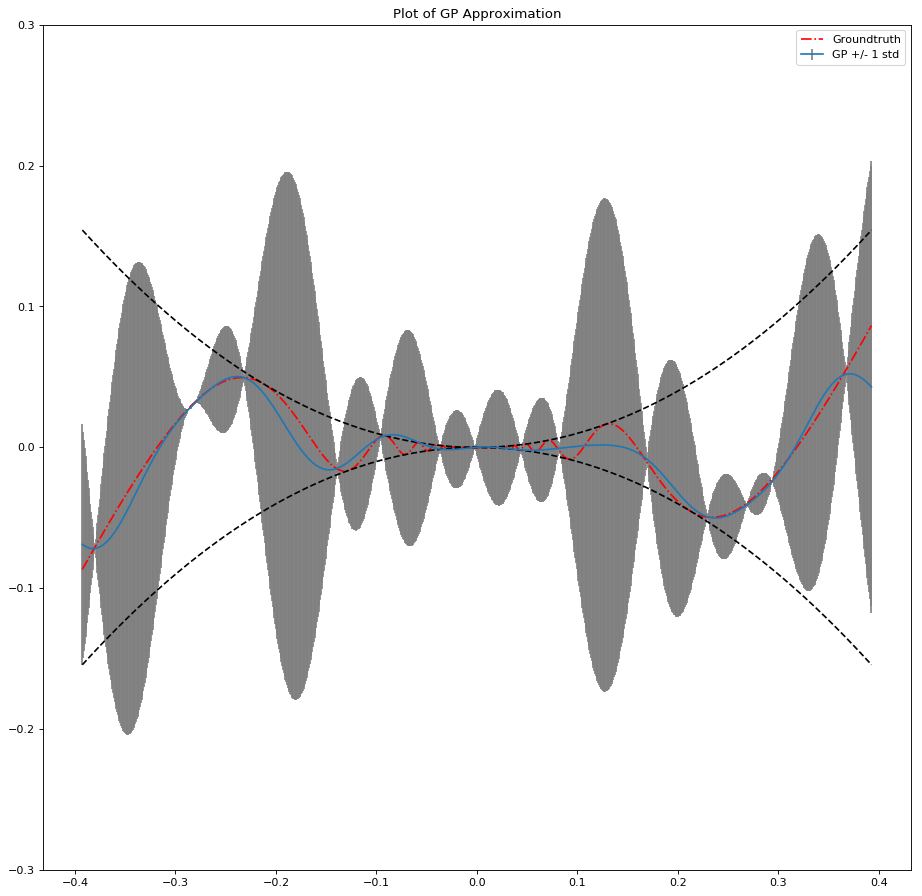

In [90]:
ytestu = np.squeeze(ytestu)
yerroru = np.squeeze(yerroru)

plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(xtest,ytestu,yerroru,ecolor='grey',label='GP +/- 1 std')
plt.ylim([-.3,.3])
plt.plot(xtest,ytrue,'r-.',label='Groundtruth')
plt.plot(xtest,ybound,'k--')
plt.plot(xtest,-ybound,'k--',)
plt.title('Plot of GP Approximation')
plt.legend()

#####Plot of GP-P

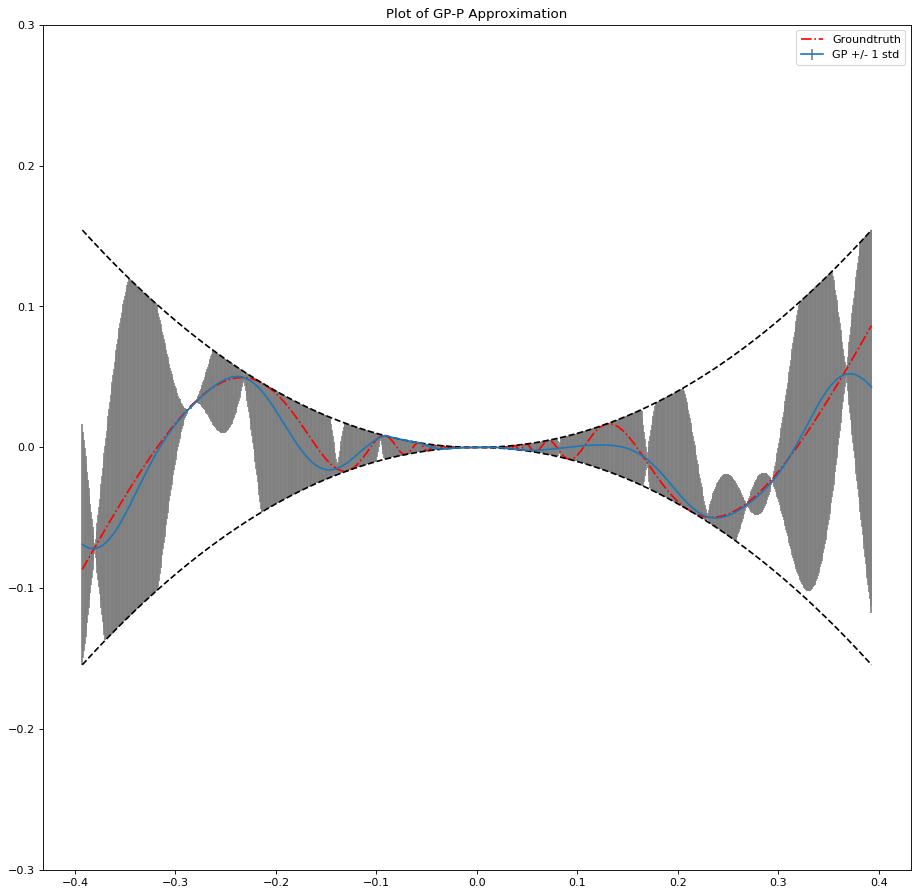

In [91]:
ytestup = np.squeeze(ytestu)
ytestup = np.minimum(ybound,ytestup)
ytestup = np.maximum(-ybound,ytestup)
yerroru = np.squeeze(yerroru)
yerrorup = np.zeros((2,nsamp))
yerrorup[1,:] = np.minimum(ybound-ytestup,yerroru)
yerrorup[0,:] = np.minimum(ybound+ytestup,yerroru)


plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
plt.ylim([-.3,.3])
plt.errorbar(xtest,ytestup,yerrorup,ecolor='grey',label='GP +/- 1 std')
plt.plot(xtest,ytrue,'r-.',label='Groundtruth')
plt.plot(xtest,ybound,'k--')
plt.ylim([-.3,.3])
plt.plot(xtest,-ybound,'k--',)
plt.title('Plot of GP-P Approximation')
plt.legend()

#####Plot of bGP-I

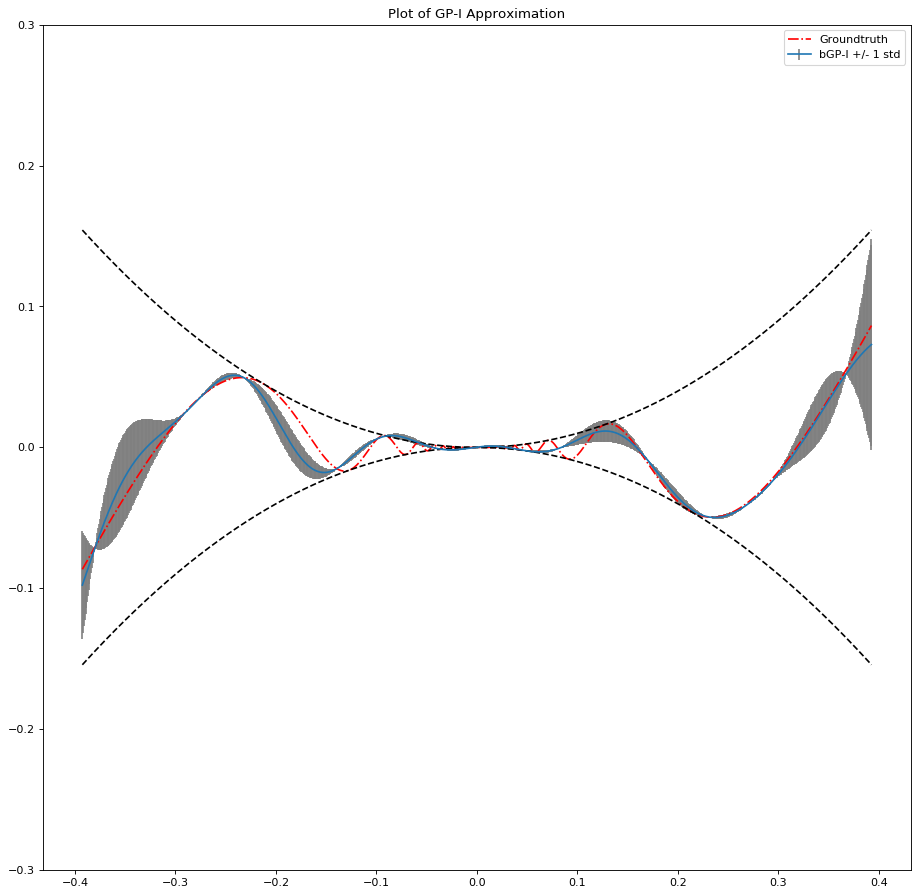

In [92]:
ytestb = np.squeeze(ytestb)

plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(xtest,ytestb,yerrorb,ecolor='grey',label='bGP-I +/- 1 std')
plt.plot(xtest,ytrue,'r-.',label='Groundtruth')
plt.plot(xtest,ybound,'k--')
plt.plot(xtest,-ybound,'k--',)
plt.title('Plot of GP-I Approximation')
plt.ylim([-.3,.3])
plt.legend()

##### Plot of Mean of bGP

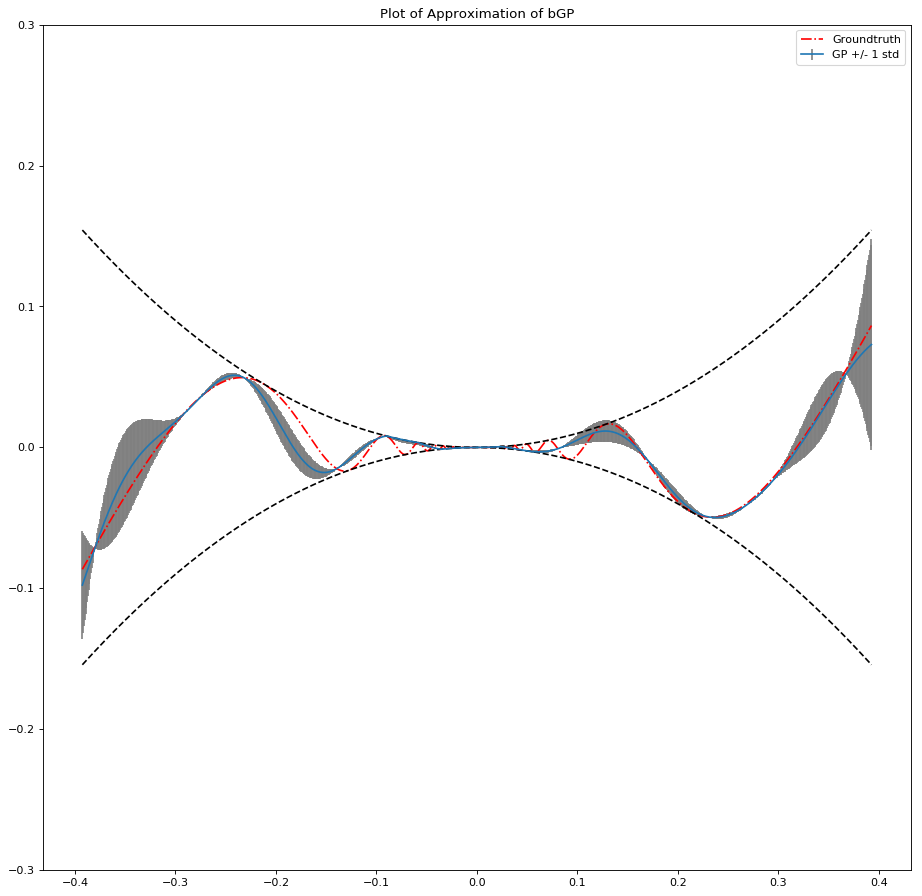

In [93]:
ytestbp = np.squeeze(ytestb)
ytestbp = np.minimum(ybound,ytestbp)
ytestbp = np.maximum(-ybound,ytestbp)
yerrorb = np.squeeze(yerrorb)
yerrorbp = np.zeros((2,nsamp))
yerrorbp[1,:] = np.minimum(ybound-ytestup,yerrorb)
yerrorbp[0,:] = np.minimum(ybound+ytestup,yerrorb)

plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(xtest,ytestbp,yerrorbp,ecolor='grey',label='GP +/- 1 std')
plt.plot(xtest,ytrue,'r-.',label='Groundtruth')
plt.plot(xtest,ybound,'k--')
plt.plot(xtest,-ybound,'k--',)
plt.title('Plot of Approximation of bGP')
plt.ylim([-.3,.3])
plt.legend()

#### Samples from each distribution

In [94]:
yu = np.random.multivariate_normal(ytestu,ycovu,num_test_gp)
yup = np.random.multivariate_normal(ytestu,ycovu,num_test_gp)
yb = np.random.multivariate_normal(ytestb,ycovb,num_test_gp)
ybp = np.random.multivariate_normal(ytestb,ycovb,num_test_gp)

for i in range(0,num_test_gp):
  yup[i,:] = np.minimum(yup[i,:],ybound)
  yup[i,:] = np.maximum(yup[i,:],-ybound)
  
for i in range(0,num_test_gp):
  ybp[i,:] = np.minimum(ybp[i,:],ybound)
  ybp[i,:] = np.maximum(ybp[i,:],-ybound)

sumsq = np.sum((ytrue-ytestu)**2)
RMSE1 = np.sqrt((1/nsamp)*sumsq)
avgval = (1/nsamp)*np.sum(ytestu)
devsqr = np.sum((ytrue-avgval)**2)
R21 = 1-sumsq/devsqr
  
sumsq = np.sum((ytrue-ytestup)**2)
RMSE2 = np.sqrt((1/nsamp)*sumsq)
avgval = (1/nsamp)*np.sum(ytestup)
devsqr = np.sum((ytrue-avgval)**2)
R22 = 1-sumsq/devsqr

sumsq = np.sum((ytrue-ytestb)**2)
RMSE3 = np.sqrt((1/nsamp)*sumsq)
avgval = (1/nsamp)*np.sum(ytestb)
devsqr = np.sum((ytrue-avgval)**2)
R23 = 1-sumsq/devsqr

sumsq = np.sum((ytrue-ytestbp)**2)
RMSE4 = np.sqrt((1/nsamp)*sumsq)
avgval = (1/nsamp)*np.sum(ytestbp)
devsqr = np.sum((ytrue-avgval)**2)
R24 = 1-sumsq/devsqr

# Validation values
print('The value of RMSE of GP is',RMSE1,'with R^2',R21)
print('The value of RMSE of GP is',RMSE2,'with R^2',R22)
print('The value of RMSE of GP is',RMSE3,'with R^2',R23)
print('The value of RMSE of GP is',RMSE4,'with R^2',R24)

The value of RMSE of GP is 0.008073349004896374 with R^2 0.9338522041573893
The value of RMSE of GP is 0.00800295208582301 with R^2 0.9350155048353231
The value of RMSE of GP is 0.007357010687398206 with R^2 0.944831371093651
The value of RMSE of GP is 0.007299772984604796 with R^2 0.9456889184430035


Sample Plots

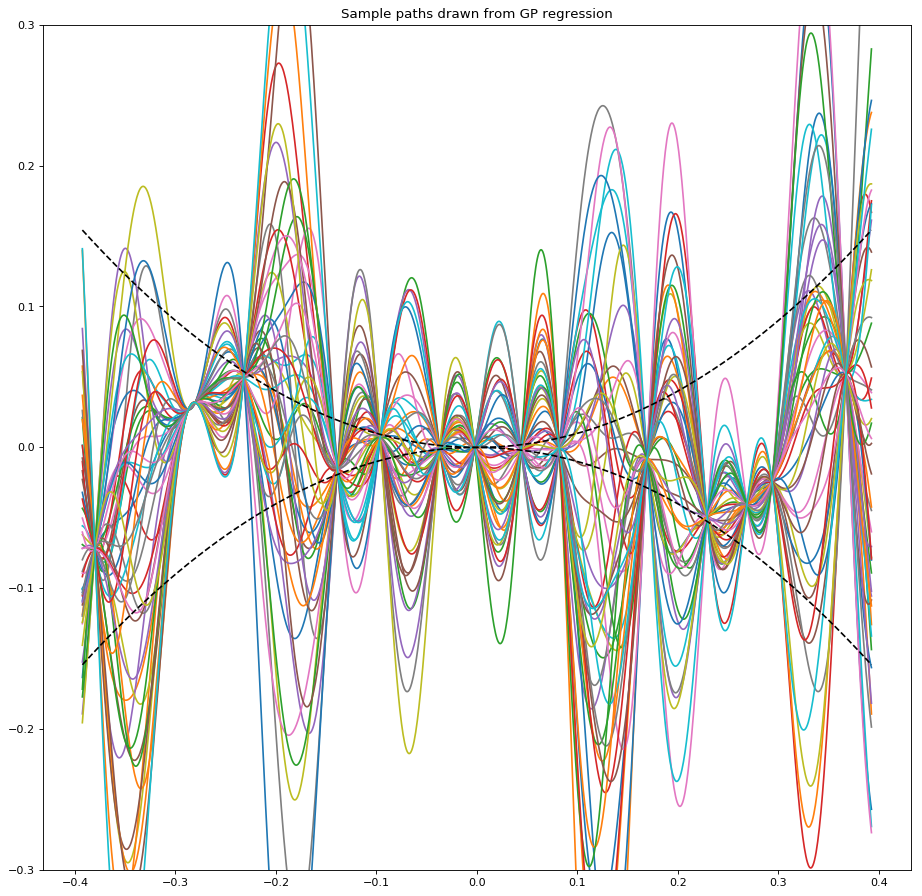

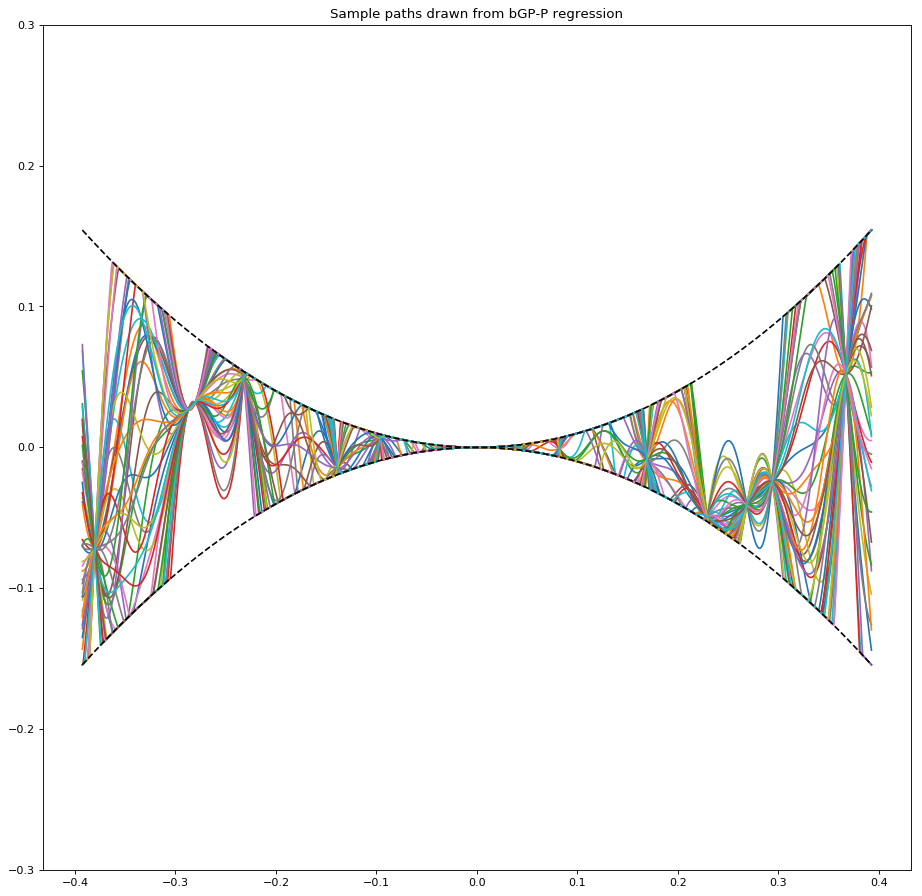

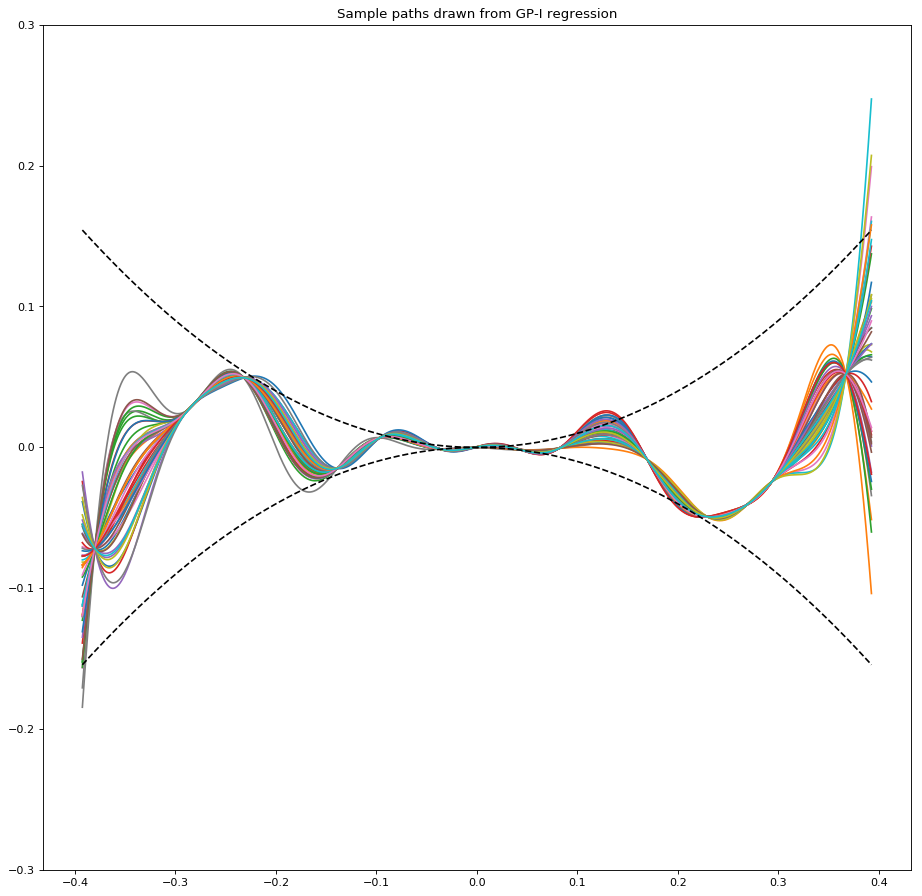

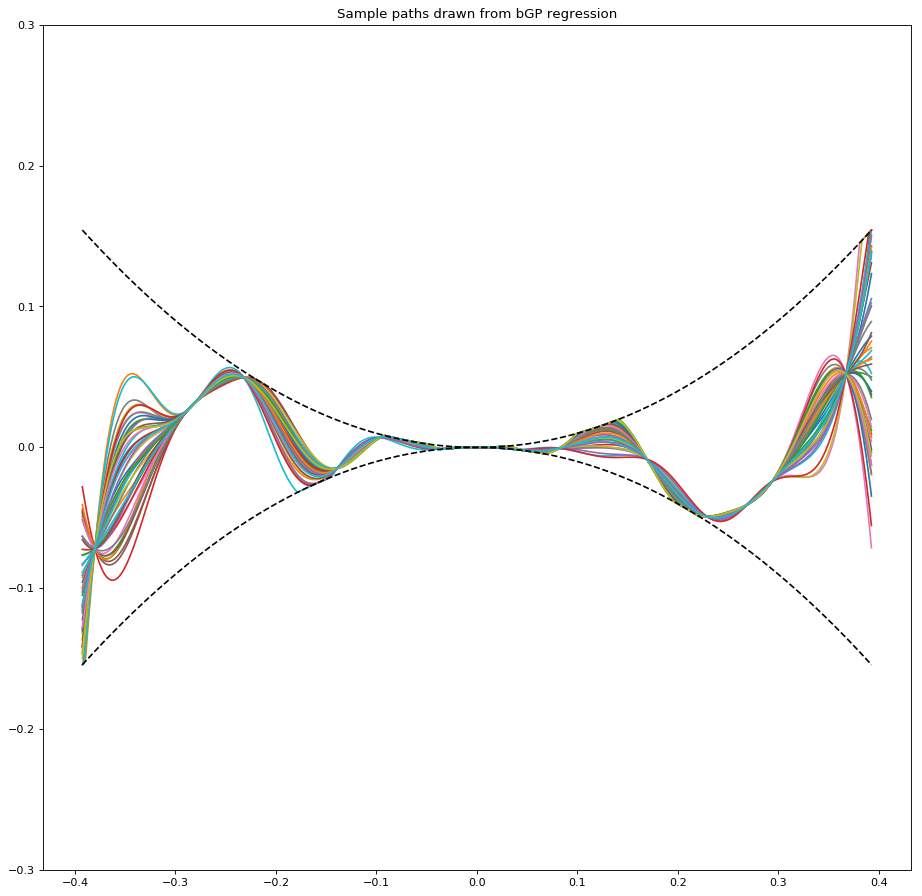

In [95]:
plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
plt.plot(xtest,np.transpose(yu))
plt.title('Sample paths drawn from GP regression')  
plt.ylim([-.3,.3])
plt.plot(xtest,ybound,'k--')
plt.plot(xtest,-ybound,'k--',)  
  
plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
plt.plot(xtest,np.transpose(yup))
plt.title('Sample paths drawn from bGP-P regression')  
plt.ylim([-.3,.3])
plt.plot(xtest,ybound,'k--')
plt.plot(xtest,-ybound,'k--',)

plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
plt.plot(xtest,np.transpose(yb))
plt.title('Sample paths drawn from GP-I regression')  
plt.ylim([-.3,.3])
plt.plot(xtest,ybound,'k--')
plt.plot(xtest,-ybound,'k--',)

plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
plt.plot(xtest,np.transpose(ybp))
plt.title('Sample paths drawn from bGP regression')  
plt.ylim([-.3,.3])
plt.plot(xtest,ybound,'k--')
plt.plot(xtest,-ybound,'k--',)